<a href="https://colab.research.google.com/github/taupork/DSA/blob/main/cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/DSA_Comp/dataset.csv"
df = pd.read_csv(CSV_PATH)
df


,Filename,Hb,Ethnicity,IndividualID,Image No,Extension
0,/content/drive/MyDrive/DSA_Comp/Dataset/Random...,7.0,NaN,100,0,jpeg
1,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_10...,10.7,NaN,7,0,heic
2,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_17...,17.3,NaN,5,2,jpeg
3,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_12...,12.0,NaN,2,4,jpg
4,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_10...,10.7,NaN,9,0,heic
5,/content/drive/MyDrive/DSA_Comp/Dataset/Random...,13.7,MiddleEasternOrigin,101,0,jpg
6,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_8....,8.0,NaN,3,1,jpg
7,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_10...,10.7,NaN,2,0,heic
8,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_12...,12.0,NaN,2,1,jpg
9,/content/drive/MyDrive/DSA_Comp/Dataset/HgB_17...,17.3,NaN,5,1,jpeg


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pillow_heif

pillow_heif.register_heif_opener()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



ModuleNotFoundError: No module named 'pillow_heif'

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image = Image.open(row["Filename"]).convert("RGB")
    if self.transform:
      image = self.transform(image)

    hb = row["Hb"]
    return image, hb


transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [ ]:
dataset = ImageDataset(df, transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=False)

In [ ]:
from torchvision import models
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet18 and remove final layer
model = models.resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # remove fc
model.eval().to(device)

features = []
targets = []

with torch.no_grad():
    for imgs, hb in loader:
        imgs = imgs.to(device)
        out = model(imgs)  # [batch, 512, 1, 1]
        out = out.view(out.size(0), -1)  # flatten -> [batch, 512]
        features.append(out.cpu().numpy())
        targets.extend(hb.numpy())

features = np.vstack(features)
targets = np.array(targets)
print("Features shape:", features.shape)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)

xgbr = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("XGBoost RMSE on image features:", rmse)


NameError: name 'features' is not defined

### RMSE: 2.081887 (With Baseline CNN & XGBoost Model)


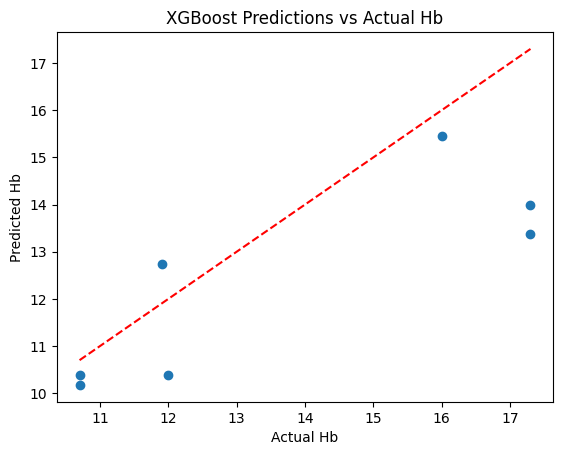

In [ ]:
import matplotlib.pyplot as plt

y_val_pred = xgbr.predict(X_val)

plt.scatter(y_val, y_val_pred)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.xlabel("Actual Hb")
plt.ylabel("Predicted Hb")
plt.title("XGBoost Predictions vs Actual Hb")
plt.show()


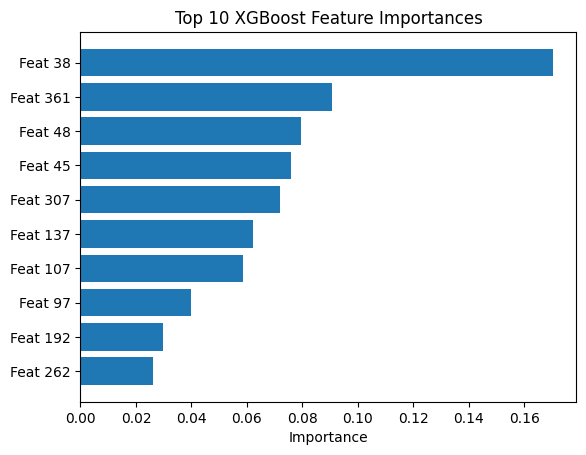

In [ ]:
importances = xgbr.feature_importances_
top_indices = np.argsort(importances)[-10:]  # top 10 features

plt.barh(range(len(top_indices)), importances[top_indices])
plt.yticks(range(len(top_indices)), [f"Feat {i}" for i in top_indices])
plt.xlabel("Importance")
plt.title("Top 10 XGBoost Feature Importances")
plt.show()
